# NAIVE BAYES

### IMPORTS

In [1]:
%matplotlib inline
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import sklearn  

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
warnings.filterwarnings("ignore")

### CARGAR LOS DATOS

In [2]:
X = pandas.read_csv('X.csv', sep=',', na_values="")
y = pandas.read_csv('y.csv', sep=',', na_values="")
print(X.shape)
print(y.shape)
y2 = np.zeros((y.shape))
y2[y == 'mucho'] = 0
y2[y == 'poco'] = 1

(7375, 1477)
(7375, 1)


### Buscar parejas correlacionadas

In [3]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import pairwise_distances
word_correlations = np.corrcoef(X, rowvar=False)
top_correlated_pairs = []
threshold = 0.5  
for i in range(word_correlations.shape[0]):
    for j in range(i + 1, word_correlations.shape[1]):
        if abs(word_correlations[i, j]) > threshold:
            top_correlated_pairs.append((i, j, word_correlations[i, j]))
print("Top Correlated Pairs")
print(len(top_correlated_pairs))

Top Correlated Pairs
53


### DIVISION DE LOS DATOS

In [4]:
(X_train, X_test,  y_train, y_test) = train_test_split(X, y2, test_size=.3, random_state=1)

### CALCULAR EL THRESHOLD

Selected threshold in 10-fold cross validation: 0.2358900931572922


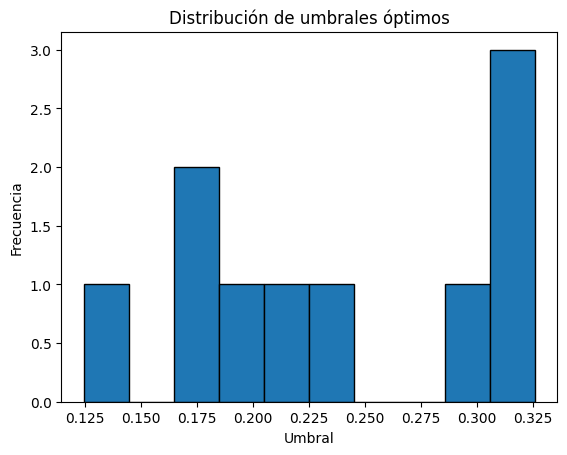

In [5]:
def filterp(th,ProbClass1):
    """ Given a treshold "th" and a set of probabilies of belonging to class 1 "ProbClass1", return predictions """ 
    y=np.zeros(ProbClass1.shape[0])
    for i,v in enumerate(ProbClass1):
        if ProbClass1[i]>th:
            y[i]=1
    return y  

clf = MultinomialNB()
lth=[]

# We do a 10 fold crossvalidation with 10 iterations
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_train, y_train):
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y2[train_index], y2[test_index] 
    # Train with the training data of the iteration 
    clf.fit(X_train2, y_train2)
    # Obtaining probablity predictions for test data of the iterarion
    probs = clf.predict_proba(X_test2)
    # Collect probabilities of belonging to class 1
    ProbClass1 = probs[:,1]
    # Sort probabilities and generate pairs (threshold, f1-for-that-threshold) 
    res = np.array([[th,f1_score(y_test2,filterp(th,ProbClass1),pos_label=1)] for th in np.sort(ProbClass1)])

    # Find the threshold that has maximum value of f1-score
    maxF = np.max(res[:,1])
    pl = np.argmax(res[:,1])
    optimal_th = res[pl,0]
    
    # Store the optimal threshold found for the current iteration
    lth.append(optimal_th)

# Compute the average threshold for all 10 iterations    
thdef = np.mean(lth)
print("Selected threshold in 10-fold cross validation:", thdef)
plt.hist(lth, bins=10, edgecolor='black')
plt.title("Distribución de umbrales óptimos")
plt.xlabel("Umbral")
plt.ylabel("Frecuencia")
plt.show()



### EVALUACIÓN DEL MODELO

0.7162223226389517
              precision    recall  f1-score   support

         0.0       0.85      0.50      0.63      1066
         1.0       0.66      0.92      0.77      1147

    accuracy                           0.72      2213
   macro avg       0.76      0.71      0.70      2213
weighted avg       0.75      0.72      0.70      2213



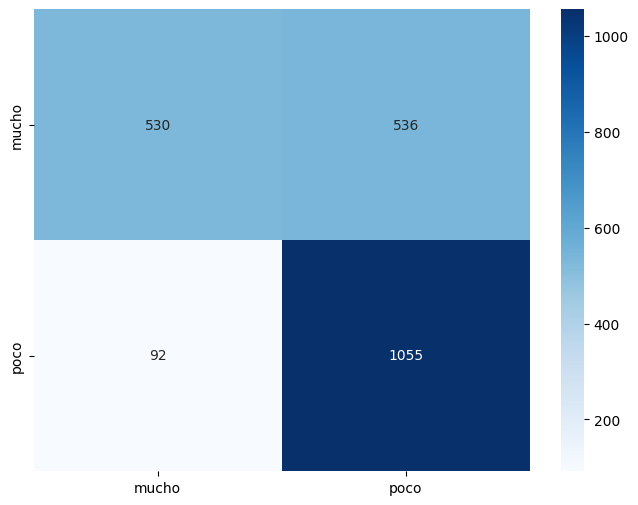

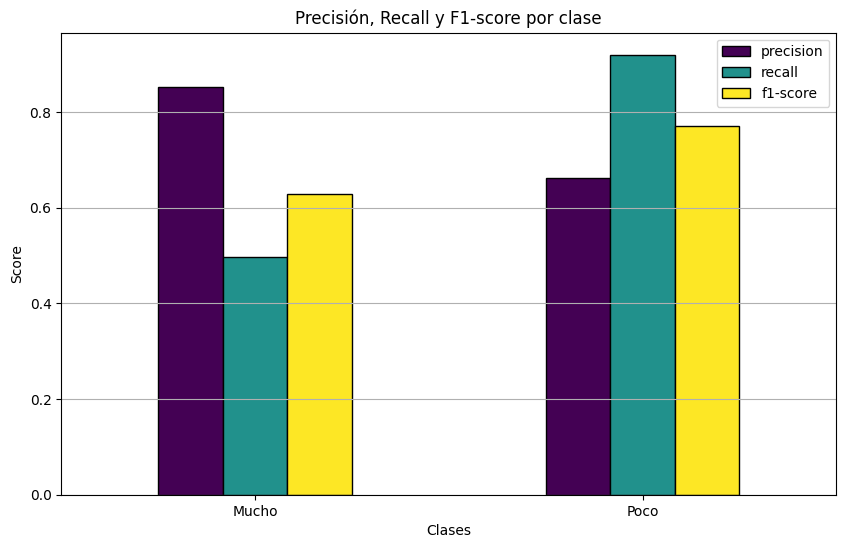

In [6]:
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)
pred = filterp(thdef, probs[:, 1])
print(sklearn.metrics.accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
cm = (confusion_matrix(y_test, pred))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.show()
# Reporte de clasificación
report = sklearn.metrics.classification_report(y_test, pred, output_dict=True)
class_names = ['Mucho', 'Poco']  
# Visualización de métricas globales del reporte
metrics = ['precision', 'recall', 'f1-score']
report_df = pandas.DataFrame(report).T
report_df = report_df[metrics]
# Plot de métricas
ax = report_df.iloc[:-3].plot(kind='bar', figsize=(10, 6), colormap='viridis', edgecolor='black')
plt.title("Precisión, Recall y F1-score por clase")
plt.ylabel("Score")
plt.xlabel("Clases")
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=0)  # Asignar nombres de clases
plt.grid(axis='y')
plt.show()

### PRUEBA SIN OPTIMIZAR EL THREESHOLD(0)

0.7144148215092635
              precision    recall  f1-score   support

         0.0       0.72      0.67      0.69      1066
         1.0       0.71      0.76      0.73      1147

    accuracy                           0.71      2213
   macro avg       0.71      0.71      0.71      2213
weighted avg       0.71      0.71      0.71      2213



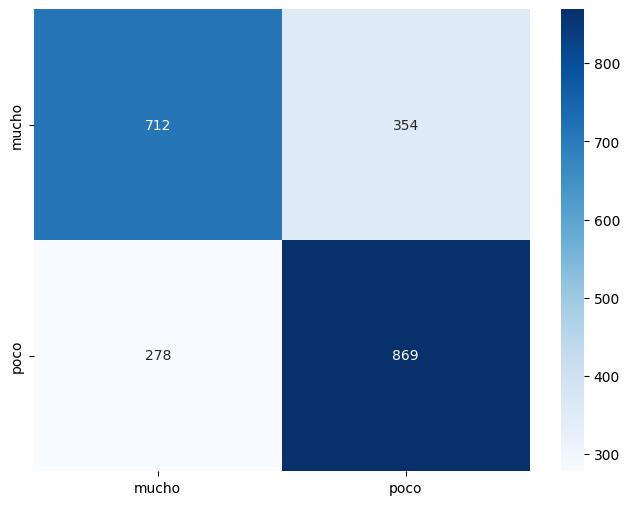

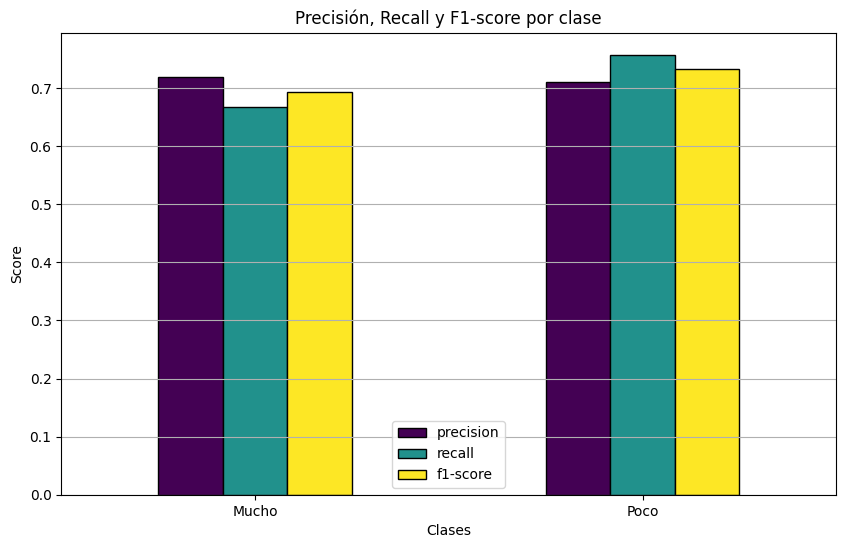

In [7]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(sklearn.metrics.accuracy_score(y_test, pred))
print(classification_report(y_test, pred))
cm = (confusion_matrix(y_test, pred))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.show()
# Reporte de clasificación
report = sklearn.metrics.classification_report(y_test, pred, output_dict=True)
class_names = ['Mucho', 'Poco']  
# Visualización de métricas globales del reporte
metrics = ['precision', 'recall', 'f1-score']
report_df = pandas.DataFrame(report).T
report_df = report_df[metrics]
# Plot de métricas
ax = report_df.iloc[:-3].plot(kind='bar', figsize=(10, 6), colormap='viridis', edgecolor='black')
plt.title("Precisión, Recall y F1-score por clase")
plt.ylabel("Score")
plt.xlabel("Clases")
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=0)  # Asignar nombres de clases
plt.grid(axis='y')
plt.show()

### Intervalo de confianza

Accuracy: 0.714
Intervalo de Confianza al 95%: (0.696, 0.733)


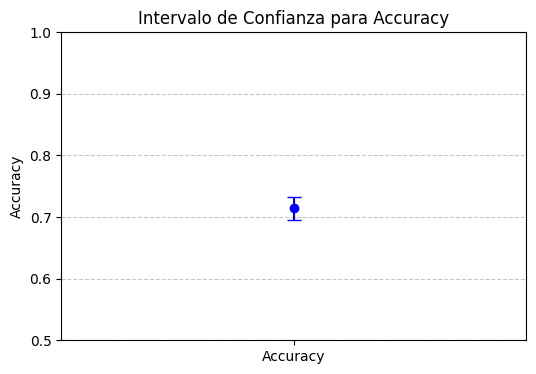

: 

In [ ]:
from statsmodels.stats.proportion import proportion_confint

# Accuracy del modelo
epsilon = sklearn.metrics.accuracy_score(y_test, pred)

# Intervalo de confianza
alpha = 0.05  # Nivel de confianza 95%
ci_lower, ci_upper = proportion_confint(count=epsilon * X_test.shape[0], 
                                        nobs=X_test.shape[0], 
                                        alpha=alpha, 
                                        method='normal')

# Mostrar intervalo de confianza
print(f"Accuracy: {epsilon:.3f}")
print(f"Intervalo de Confianza al 95%: ({ci_lower:.3f}, {ci_upper:.3f})")

# Calcular el error positivo y negativo
yerr = np.array([[epsilon - ci_lower], [ci_upper - epsilon]]).reshape(2, -1)

# Visualización del intervalo de confianza
plt.figure(figsize=(6, 4))
plt.errorbar(x=["Accuracy"], y=[epsilon], yerr=yerr, fmt='o', color='blue', capsize=5)
plt.title("Intervalo de Confianza para Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)  # Ajustar límites para claridad
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
